In [1]:
import os
import numpy as np
from scipy.linalg import norm
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle


# Basic methods

In [2]:
def get_area_moment_of_inertia_circ(D):
    """ Gets area moment of inertia for a filled circle cross-section
    D: cross-section diameter"""
    Iyy = (np.pi*D**4)/64
    return Iyy

def get_area_moment_of_inertia_rect(b, h):
    """ Gets area moment of inertia for a filled rectangular cross-section
    b: cross-section breadth
    h: cross-section height """
    Iyy = (b*h**3)/12
    return Iyy

def get_equivalent_thickness_SPW(D, A):
    """ Gets equivalent thickness for plate to model SPW in PLAXIS3D
    D: pile diameter
    A: c/c spacing between two neighboring piles"""
    h = (12*np.pi*D**4/64/(2*A))**(1/3)
    return h

In [3]:
D = 1.5 #m
A = 0.87 #m
h = get_equivalent_thickness_SPW(D, A)
print('Equivalent wall thickness is {0}'.format(h))

Equivalent wall thickness is 1.1967101583076327


# Methods for secant pile shaft

In [4]:
def get_parameters_secant_piles(ri, n_pieces, D, L, v=0.75, shaft_name='Shaft', print_results=True):
    """ Get parameters for secant piles
    ri: inner shaft radius
    n_pieces: numer of piles
    D: pile diameter
    L: pile length
    v: percentage of verticality
    """
    if print_results:
        print('INPUT GEOMETRY {0}...'.format(shaft_name))
        print('Inner diameter of shaft 2*ri = {:.2f} m'.format(2*ri))
        print('Numer of piles n_pieces = {}'.format(n_pieces))
        print('Pile diameter = {:.2f} m'.format(D))
        print('Pile length = {:.2f} m'.format(L))
        print('Drilling verticality = {:.2f}%'.format(v))
    
    a = np.pi*(2*ri + D)/n_pieces # c/c spacing between 2 neighboring piles at shaft's center line
    t_top = D - a # interlock
    d_top = 2*np.sqrt((D/2)**2 - (a/2)**2) # overlapped thickness
    x = L*v/100 # deviation at bottom of shaft, m
    
    if print_results:   
        print('\nOUTPUT GEOMETRY {0}...'.format(shaft_name))
        print('C/c spacing at top of shaft a = {:.2f} m'.format(a))
        print('Overcut at top of shaft t = {:.2f} cm'.format(t_top*100))
        print('Effective thickness at top of shaft d = {:.2f} cm'.format(d_top*100))
        print('Deviation at bottom of shaft dx = {:.2f} cm'.format(x*100))
    
    t_eff = t_top - 2*x # effective/overlapped thickness at toe of shaft, m
    if t_eff > 0:
        d_eff = 2*np.sqrt((D/2)*t_eff - (t_eff/2)**2) # overlapped thickness, m    
        if print_results:
            print('Overcut at bottom of shaft t_eff = {:.2f} cm'.format(t_eff*100))
            print('Effective thickness at bottom of shaft d_eff = {:.2f} cm'.format(d_eff*100))
    else:
        d_eff = np.nan
        if print_results:
            print('PILES DO NOT TOUCH IN BASE OF SHAFT!!')

    return a, t_top, d_top, x, t_eff, d_eff

def get_design_hoop_stress_from_effective_thickeness(F_hoop, d_eff, gamma_G):
    """ Gets design hoop stress from hoop force and effective thickness
    F_hoop: hoop force in kN/m
    d_eff: efective thickness in m
    gamma_G: safety factor on load"""
    sigma_cd = gamma_G*F_hoop/d_eff/1000
    return sigma_cd # MPa

def get_design_hoop_stress_for_plain_concrete(f_ck, alpha_cc, gamma_c):
    """ Gets design hoop stress for plain concrete
    f_ck: compressive strength (cylinder)
    alpha_cc: coefficient for long-term effect
    gamma_c: satefy factor on material"""
    f_cd = alpha_cc*f_ck/gamma_c
    return f_cd

def check_for_hoop_force(F_hoop, d_eff, gamma_G, f_ck, alpha_cc=0.7, gamma_c=1.5):
    """ Checks for hoop stress"""
    sigma_cd = get_design_hoop_stress_from_effective_thickeness(F_hoop, d_eff, gamma_G)
    f_cd = get_design_hoop_stress_for_plain_concrete(f_ck, alpha_cc, gamma_c)
    
    print('N2 = {0:.2f} kN/m, d_eff = {1:.2f} cm, gamma_G = {2:.2f}, f_ck = {3:.2f} MPa, alpha_cc = {4:.2f}, gamma_c = {5:.2f}'.format(F_hoop, d_eff*100, gamma_G, f_ck, alpha_cc, gamma_c))
    if sigma_cd < f_cd:
        print('Hoop stress = {0:.2f} MPa < design hoop stress = {1:.2f} MPa: PASSED'.format(sigma_cd, f_cd))
    else:
        print('Hoop stress = {0:.2f} MPa > design hoop stress = {1:.2f} MPa: NOT PASSED'.format(sigma_cd, f_cd))

def plot_shaft(ri, n_pieces, D, dev=0.0, shaft_name='Shaft'):
    angles = np.linspace(0, 2*np.pi-2*np.pi/n_pieces, n_pieces)
    r = ri + D/2
    
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    
        
    pile_types = ['primary', 'secondary']
    #pile_colors = ['blue', 'red']
    pile_colors = ['white', 'white']
    fig, ax = plt.subplots(1, 2)
    
    # top of shaft
    for i in range(0,len(angles),2):
        circle_p = plt.Circle((x[i],y[i]), D/2, facecolor=pile_colors[0], edgecolor='black', zorder=0, alpha=0.3, label=pile_types[0])
        ax[0].add_patch(circle_p)       
    for i in range(1, len(angles), 2):
        circle_s = plt.Circle((x[i],y[i]), D/2, facecolor=pile_colors[1], edgecolor='black', zorder=0, alpha=0.3, linewidth=2.0, label=pile_types[1])
        ax[0].add_patch(circle_s)
        
    # deviations
    #angles_deviation = 2*np.pi*np.random.rand(angles.size) # random angle of deviation for each of the piles
    angles_deviation = 2*np.pi*np.random.uniform(0,1,angles.size) # random angle of deviation for each of the piles
    x = x + dev*np.cos(angles_deviation)
    y = y + dev*np.sin(angles_deviation)
    
    # bottom of shaft
    for i in range(0,len(angles),2):
        circle_p = plt.Circle((x[i],y[i]), D/2, facecolor=pile_colors[0], edgecolor='black', zorder=0, alpha=0.3, label=pile_types[0])
        ax[1].add_patch(circle_p)       
    for i in range(1, len(angles), 2):
        circle_s = plt.Circle((x[i],y[i]), D/2, facecolor=pile_colors[1], edgecolor='black', zorder=0, alpha=0.3, linewidth=2.0, label=pile_types[1])
        ax[1].add_patch(circle_s)

    ax[0].set_title(shaft_name + ' at top')
    ax[1].set_title(shaft_name + ' at base (deviation {0:.1f} cm)'.format(dev*100))
    for axi in ax:
        axi.autoscale_view()
        axi.set_aspect('equal')
        #ax.legend()
        #handles, labels = plt.gca().get_legend_handles_labels()
        #by_label = OrderedDict(zip(labels, handles))
        #plt.legend(by_label.values(), by_label.keys())
    plt.show()


## Plot shaft 3D

In [5]:
def data_for_cylinder_2_points(p0, p1, R):
    """ Gets grid data for cylinder
    """
    v = p1 - p0
    mag = norm(v)
    v = v/mag # unit vector
    
    #make some vector not in the same direction as v
    not_v = np.array([1, 0, 0])
    if (v == not_v).all():
        not_v = np.array([0, 1, 0])
    #make vector perpendicular to v
    n1 = np.cross(v, not_v)
    #normalize n1
    n1 /= norm(n1)
    #make unit vector perpendicular to v and n1
    n2 = np.cross(v, n1)
    #surface ranges over t from 0 to length of axis and 0 to 2*pi
    t = np.linspace(0, mag, 10)
    theta = np.linspace(0, 2 * np.pi, 20)
    #use meshgrid to make 2d arrays
    t, theta = np.meshgrid(t, theta)
    #generate coordinates for surface
    X, Y, Z = [p0[i] + v[i] * t + R * np.sin(theta) * n1[i] + R * np.cos(theta) * n2[i] for i in [0, 1, 2]]

    return X, Y, Z

    
def plot_cylinder_2points(axis, point0, point1, radius, color='blue'):
    """ Plots a cylinder by connecting 2 points
    """
    Xc, Yc, Zc = data_for_cylinder_2_points(point0, point1, radius)
    axis.plot_surface(Xc, Yc, Zc, color=color)
    #plot axis
    axis.plot(*zip(point0, point1), color = 'red')
 

def plot_shaft_3d(ri, n_pieces, D, L, dev=0.0, shaft_name='Shaft'):
    """ Plots shaft in 3D with random drilling deviation
    dev: maxinum deviation in meter"""
    angles = np.linspace(0, 2*np.pi-2*np.pi/n_pieces, n_pieces)
    r = ri + D/2   
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    
    # deviations
    #angles_deviation = 2*np.pi*np.random.rand(angles.size) # random angle of deviation for each of the piles
    angles_deviation = 2*np.pi*np.random.uniform(0,1,angles.size) # random angle of deviation for each of the piles
    x_dev = x + dev*np.cos(angles_deviation)
    y_dev = y + dev*np.sin(angles_deviation)
    
        
    pile_types = ['primary', 'secondary']
    #pile_colors = ['blue', 'red']
    pile_colors = ['white', 'white']
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    for i in range(0,len(angles),2):
        point0 = np.array([x_dev[i], y_dev[i], 0])
        point1 = np.array([x[i], y[i], L])
        plot_cylinder_2points(ax, point0, point1, D/2)
        
    for i in range(1, len(angles), 2):
        point0 = np.array([x_dev[i], y_dev[i], 0])
        point1 = np.array([x[i], y[i], L])
        plot_cylinder_2points(ax, point0, point1, D/2, color='orange')
        
    ax.set_title(shaft_name + ' 3D')
    #ax.set_aspect('equal')
    set_axis_equal_3d(ax)
    plt.show()
    
    
def set_axis_equal_3d(ax):
    """ Sets equal aspect ratio
    """
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

## Using interact for tuning

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(ri=5.85/2, D=[0.6, 0.75, 0.88, 1.0, 1.2, 1.5], L=58, n_pieces=35)
def calculate_secant_pile_shaft(ri, D, L, n_pieces):
    a, t_top, d_top, x, t_eff, d_eff = get_parameters_secant_piles(ri, n_pieces, D, L, v=0.3)

    %matplotlib inline
    plot_shaft(ri, n_pieces, D, x)

    %matplotlib inline
    plot_shaft_3d(ri, n_pieces, D, L, x)

interactive(children=(FloatSlider(value=2.925, description='ri', max=8.774999999999999, min=-2.925), Dropdown(…

## Design checks

INPUT GEOMETRY DS-2...
Inner diameter of shaft ri = 6.80 m
Numer of piles n_pieces = 30
Pile diameter = 1.50 m
Pile length = 40.20 m
Drilling verticality = 0.75%

OUTPUT GEOMETRY DS-2...
C/c spacing at top of shaft a = 0.87 m
Overcut at top of shaft t = 63.08 cm
Effective thickness at top of shaft d = 122.25 cm
Deviation at bottom of shaft dx = 30.15 cm
Overcut at bottom of shaft t_eff = 2.78 cm
Effective thickness at bottom of shaft d_eff = 28.76 cm


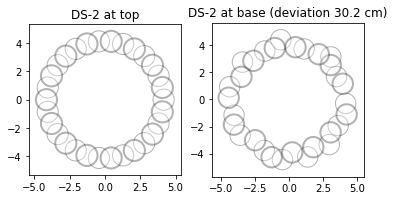

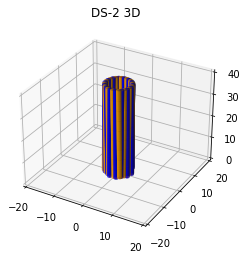


CHECK FOR HOOP FORCE AT BASE OF SHAFT
N2 = 700.00 kN/m, d_eff = 28.76 cm, gamma_G = 1.35, f_ck = 10.00 MPa, alpha_cc = 0.70, gamma_c = 1.50
Hoop stress = 3.29 MPa < design hoop stress = 4.67 MPa: PASSED

CHECK FOR HOOP FORCE AT LEVEL WITH OPENING
N2 = 3500.00 kN/m, d_eff = 76.68 cm, gamma_G = 1.35, f_ck = 16.00 MPa, alpha_cc = 0.70, gamma_c = 1.50
Hoop stress = 6.16 MPa < design hoop stress = 7.47 MPa: PASSED


In [7]:
## DS-2
shaft_name = 'DS-2'
ri = 3.4 # inner radius of shaft, m
D = 1.5 # pile diameter, m
L = 40.2 # shaft length, m
n_pieces = 30 # number of piles 

a, t_top, d_top, x, t_eff, d_eff = get_parameters_secant_piles(ri, n_pieces, D, L, shaft_name=shaft_name)

#h = get_equivalent_thickness_SPW(D, a)
#print('\nEquivalent plate thickness is {:.2f} m'.format(h))

%matplotlib inline
plot_shaft(ri, n_pieces, D, x, shaft_name=shaft_name)

%matplotlib inline
plot_shaft_3d(ri, n_pieces, D, L, x, shaft_name=shaft_name)

# check for hoop force at base of shaft
F_hoop = 700.0 # kN/m
gamma_G = 1.35
f_ck = 10.0 # MPa
print('\nCHECK FOR HOOP FORCE AT BASE OF SHAFT')
check_for_hoop_force(F_hoop, d_eff, gamma_G, f_ck, alpha_cc=0.7, gamma_c=1.5)

# check for hoop force at opening
F_hoop = 3500.0 # kN/m
gamma_G = 1.35
f_ck = 16.0 # MPa
a, t_top, d_top, x, t_eff, d_eff = get_parameters_secant_piles(ri, n_pieces, D, 28.0, shaft_name=shaft_name, print_results=False) # d_eff at opening, L = 28 m
print('\nCHECK FOR HOOP FORCE AT LEVEL WITH OPENING')
check_for_hoop_force(F_hoop, d_eff, gamma_G, f_ck, alpha_cc=0.7, gamma_c=1.5)

INPUT GEOMETRY MTS-8...
Inner diameter of shaft ri = 7.00 m
Numer of piles n_pieces = 28
Pile diameter = 1.50 m
Pile length = 33.50 m
Drilling verticality = 0.75%

OUTPUT GEOMETRY MTS-8...
C/c spacing at top of shaft a = 0.95 m
Overcut at top of shaft t = 54.63 cm
Effective thickness at top of shaft d = 115.78 cm
Deviation at bottom of shaft dx = 25.12 cm
Overcut at bottom of shaft t_eff = 4.38 cm
Effective thickness at bottom of shaft d_eff = 35.98 cm

Equivalent plate thickness is 1.16 m


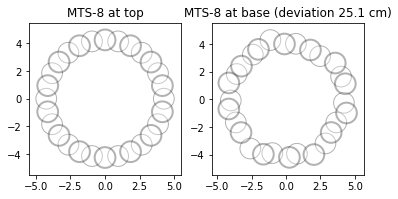

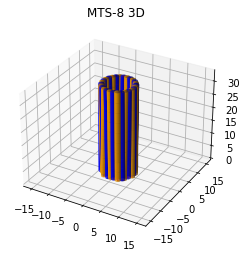


CHECK FOR HOOP FORCE AT BASE OF SHAFT
N2 = 720.00 kN/m, d_eff = 35.98 cm, gamma_G = 1.35, f_ck = 10.00 MPa, alpha_cc = 0.70, gamma_c = 1.50
Hoop stress = 2.70 MPa < design hoop stress = 4.67 MPa: PASSED

CHECK FOR HOOP FORCE AT LEVEL WITH OPENING
N2 = 1000.00 kN/m, d_eff = 78.09 cm, gamma_G = 1.35, f_ck = 10.00 MPa, alpha_cc = 0.70, gamma_c = 1.50
Hoop stress = 1.73 MPa < design hoop stress = 4.67 MPa: PASSED


In [8]:
## MTS-8
shaft_name = 'MTS-8'
ri = 3.5 # inner radius of shaft, m
D = 1.5 # pile diameter, m
L = 33.5 # shaft length, m
n_pieces = 28 # number of piles 

a, t_top, d_top, x, t_eff, d_eff = get_parameters_secant_piles(ri, n_pieces, D, L, shaft_name=shaft_name)

h = get_equivalent_thickness_SPW(D, a)
print('\nEquivalent plate thickness is {:.2f} m'.format(h))

%matplotlib inline
plot_shaft(ri, n_pieces, D, x, shaft_name=shaft_name)

%matplotlib inline
plot_shaft_3d(ri, n_pieces, D, L, x, shaft_name=shaft_name)

# check for hoop force at base of shaft
F_hoop = 720.0 # kN/m
gamma_G = 1.35
f_ck = 10.0 # MPa
print('\nCHECK FOR HOOP FORCE AT BASE OF SHAFT')
check_for_hoop_force(F_hoop, d_eff, gamma_G, f_ck, alpha_cc=0.7, gamma_c=1.5)

# check for hoop force at opening
F_hoop = 1000.0 # kN/m
gamma_G = 1.35
f_ck = 10.0 # MPa
a, t_top, d_top, x, t_eff, d_eff = get_parameters_secant_piles(ri, n_pieces, D, 21.8, shaft_name=shaft_name, print_results=False) # d_eff at opening, L = 21.8 m
print('\nCHECK FOR HOOP FORCE AT LEVEL WITH OPENING')
check_for_hoop_force(F_hoop, d_eff, gamma_G, f_ck, alpha_cc=0.7, gamma_c=1.5)